In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('cleaned_city_Day.csv')
df.head(10)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI,AQI_Bucket,Month,Year
0,Ahmedabad,2015-01-01,58.37,107.96,0.92,18.22,17.15,14.89,0.920,27.64,133.36,149.0,Moderate,1,2015
1,Ahmedabad,2015-01-02,58.37,107.96,0.97,15.69,16.46,14.89,0.970,24.55,34.06,106.0,Moderate,1,2015
2,Ahmedabad,2015-01-03,58.37,107.96,17.40,19.30,29.70,14.89,17.400,29.07,30.70,303.0,Very Poor,1,2015
3,Ahmedabad,2015-01-04,58.37,107.96,1.70,18.48,17.97,14.89,1.700,18.59,36.08,106.0,Moderate,1,2015
4,Ahmedabad,2015-01-05,58.37,107.96,22.10,21.42,37.76,14.89,22.100,39.33,39.31,330.0,Very Poor,1,2015
5,Ahmedabad,2015-01-06,58.37,107.96,45.41,38.48,81.50,14.89,45.410,45.76,46.51,401.0,Severe,1,2015
6,Ahmedabad,2015-01-07,58.37,107.96,112.16,40.62,130.77,14.89,112.160,32.28,33.47,401.0,Severe,1,2015
7,Ahmedabad,2015-01-08,58.37,107.96,80.87,36.74,96.75,14.89,80.870,38.54,31.89,401.0,Severe,1,2015
8,Ahmedabad,2015-01-09,58.37,107.96,29.16,31.00,48.00,14.89,29.160,58.68,25.75,372.0,Very Poor,1,2015
9,Ahmedabad,2015-01-10,58.37,107.96,16.28,7.04,0.00,14.89,16.245,8.29,4.55,289.0,Poor,1,2015


In [3]:
# Separate features and response variables
x = df.iloc[:, 2:11]
y = df.loc[:, 'AQI']

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=42)

In [5]:
print(f"Actual Data size: {df.shape}")
print(f"Training Data size: {x_train.shape}")
print(f"Test Data size: {x_test.shape}")

Actual Data size: (27963, 15)
Training Data size: (19574, 9)
Test Data size: (8389, 9)


In [6]:
# Scaling of feature variables
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [7]:
# Scaling of response variable
from sklearn.preprocessing import StandardScaler
sc_y = StandardScaler()
y_train = sc_y.fit_transform(np.array(y_train).reshape(-1,1))
y_test = sc_y.transform(np.array(y_test).reshape(-1,1))

In [8]:
from xgboost import XGBRegressor
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': randint(100,300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01,0.2),
    'subsample': uniform(0.7, 0.3), # Samples between 0.7 and 1.0
    'colsample_bytree': uniform(0.7, 0.3), # Samples between 0.7 and 1.0
    'gamma': loguniform(1e-5, 1.0)
}

random_search = RandomizedSearchCV(estimator=XGBRegressor(), param_distributions=param_grid,
                                   scoring='r2', n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

random_search.fit(x_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best R2:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'colsample_bytree': 0.8156249507619748, 'gamma': 1.2017974027309955e-05, 'learning_rate': 0.056178765124429805, 'max_depth': 6, 'n_estimators': 210, 'subsample': 0.9049790556476374}
Best R2: 0.9090113430390161


In [9]:
best_model = random_search.best_estimator_
y_pred_xg = best_model.predict(x_test)

In [10]:
# tuned parameters
random_search.best_params_

{'colsample_bytree': 0.8156249507619748,
 'gamma': 1.2017974027309955e-05,
 'learning_rate': 0.056178765124429805,
 'max_depth': 6,
 'n_estimators': 210,
 'subsample': 0.9049790556476374}

In [11]:
# De-scaling of response variable
y_test = sc_y.inverse_transform(y_test.reshape(-1,1))
y_pred_xg = sc_y.inverse_transform(y_pred_xg.reshape(-1,1))
y_pred_xg[:5]

array([[ 77.86651 ],
       [361.6596  ],
       [112.401146],
       [ 77.40395 ],
       [ 88.77721 ]], dtype=float32)

In [12]:
# Mathematical measure to check the accuracy of prediction
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred_xg)
mse = mean_squared_error(y_test, y_pred_xg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xg)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 20.17454662770903
MSE: 1965.584617944534
RMSE: 44.33491420928357
R2: 0.8843829397363967


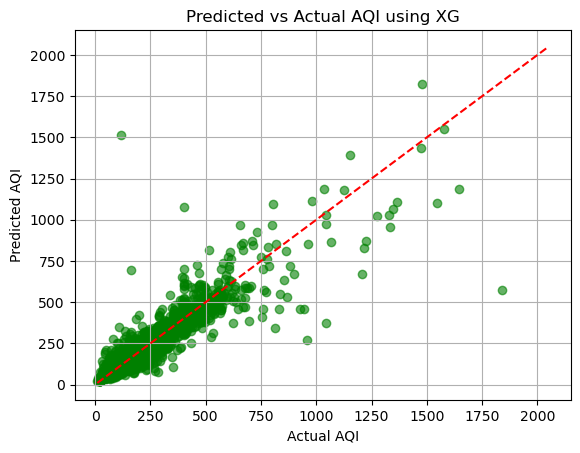

In [13]:
# Plotting scatterplot 
plt.scatter(y_test, y_pred_xg, color='green', alpha=0.6)

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 45-degree reference line
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Predicted vs Actual AQI using XG")
plt.grid(True)
plt.show()


In [14]:
import random
random.seed(42)
random_integer = random.randint(0, 8000)

df_XGB = pd.DataFrame({'Actual':y_test[random_integer:random_integer+70].flatten(), 'Predicted':y_pred_xg[random_integer:random_integer+70].flatten()})
df_XGB.head(10)

,Actual,Predicted
0,69.0,59.826447
1,413.0,427.556366
2,189.0,165.227661
3,78.0,124.029800
4,179.0,162.897217
5,71.0,72.838257
6,110.0,94.835945
7,323.0,289.054962
8,65.0,71.010345
9,214.0,215.565750


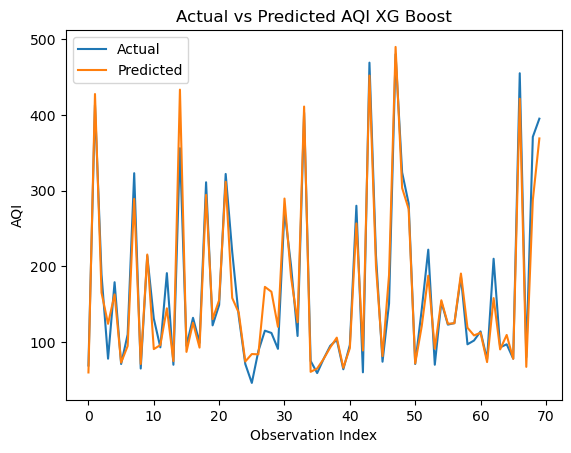

In [16]:
# Plotting line diagram (IT IS TO BE NOTED THAT THE X-AXIS DOES NOT REPRESENT TIME POINTS)
df_XGB.plot(kind='line')
plt.xlabel('Observation Index')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI XG Boost')
plt.savefig('XGB_lineDiag.png')
plt.show()